# Introduction

GANs' potential is huge because they can learn to mimic any distribution of data, including speech, images, prose, etc.. GAN basically consists of two kinds of algorithms, generative and discriminative ones. The discriminative algorithm predicts a category (or label) which the feature belongs. On the contrast, the generative algorithm predicts the features given a label. These two opposite algorithms are reasons why the network's name is adversarial.

For example, we train a discriminative model to recognize whether an email (content) is spam or not. That is, the discriminative model calculates a probability $p\{y|x\}$, which $y$ is the category result (Yes or No) and $x$ is the word. The probability means how possible the spam is when given a word $x$. On the other hand, the generative model cares about **how to get $x$** when given a category $y$. That is, the generative model tries to learn the key feature consisting of $y$. The generative model is also a classifier.

In short, the discriminative model learns the boundary between classes and the generative model learns the distribution of individual classes. In simple,  you can think of GAN as the combination of a counterfeiter and a cop in a game of cat and mouse. 

# How GANs Work

The generative neural network (called generator) generates new data instances, while the other discriminative one evaluates them for authenticity. For example, the discriminative decides whether each instance of data it reviews belongs to the actual training dataset or not.

In the following, we are going to use MINST dataset as the example. The generator creates new images that pass to the discriminator and it hopes those images are deemed authentic (but the truth is the generating images are fake). On the other hand, the discriminator learns to identify images from the generator as fake.

## Basic Workflow

* The generator takes in random numbers and returns an image.
* Both the generated image is fed into the discriminator alongside a stream of the images from the actual dataset.
* The discriminator identifies both real and generative images and returns probabilities between 0 (fake) and 1 (authentic).

![](https://skymind.ai/images/wiki/gan_schema.png)

The above image is referred from https://skymind.ai/wiki/generative-adversarial-network-gan and is further referred from O'Reily.

## Neural Network Design

The discriminator network is a standard convolutional network recognizing the images fed to it. It is a binary classifier labelling images as real or fake. The generator is an inverse convolutional network. A standard convolutional network takes an image as input and downsamples it to produce a probability. On the contrary, an inverse convolutional network takes a vector of random noises and upsamples it to an image.

Both networks are trying to optimize different objective functions (or loss functions), in a zero-sum game.

![](https://skymind.ai/images/wiki/GANs.png)

The above image is referred from https://skymind.ai/wiki/generative-adversarial-network-gan.

# Training GAN Tips

* **Hold the Adversary in the constant**

When you train the discriminator, hold the generator values constant; and when you train the generator, hold the discriminator values constant. This gives one a better read on the gradient it must learn by.

* **Pretrain the discriminator first**

Pretraining the discriminator first before pretraining the generator gives a clear gradient.

* **the balance is necessary**

Each side of the GAN can overpower the other one. If the discriminator is too good, it will return values closing to 0 or 1. This gives the generator little gradient changes to update. If the generator is too good, it will persistently exploit the weakness to the discriminator and leads to increase false negatives (or type II error).

* **more training time**

# MNIST example in Keras

In [1]:
from keras.models import Sequential, Model
from keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Flatten, Input
from keras.optimizers import Adam
from keras.datasets import mnist

import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [4]:
class GAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

        # Build and compile the generator
        self.generator = self.build_generator()
        self.generator.compile(loss='binary_crossentropy', optimizer=optimizer)

        # The generator takes noise as input and generated imgs
        z = Input(shape=(100,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The valid takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator) takes
        # noise as input => generates images => determines validity
        self.combined = Model(inputs=z, outputs=valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
        
    def build_discriminator(self):
        
        img_shape = (self.img_rows, self.img_cols, self.channels)

        model = Sequential()

        model.add(Flatten(input_shape=img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=img_shape)
        validity = model(img)

        return Model(img, validity)

    def build_generator(self):

        noise_shape = (100,)

        model = Sequential()

        model.add(Dense(256, input_shape=noise_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=noise_shape)
        img = model(noise)

        return Model(noise, img)

    def train(self, epochs, batch_size=128, save_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)

        half_batch = int(batch_size / 2)

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (half_batch, 100))

            # Generate a half batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, 100))

            # The generator wants the discriminator to label the generated samples
            # as valid (ones)
            valid_y = np.array([1] * batch_size)

            # Train the generator
            g_loss = self.combined.train_on_batch(noise, valid_y)

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                # Plot the progress
                print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
                
                self.save_imgs(epoch)

    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, 100))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________
____

/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:479: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.613414, acc.: 79.69%] [G loss: 0.674404]


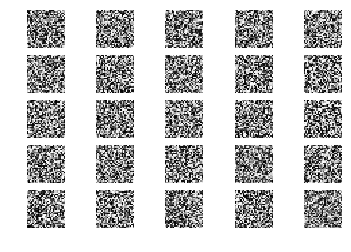

5000 [D loss: 0.714259, acc.: 45.31%] [G loss: 0.889995]


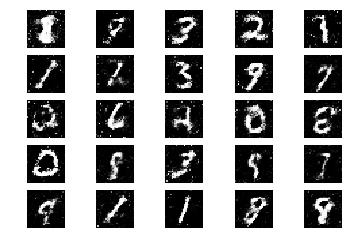

10000 [D loss: 0.684532, acc.: 54.69%] [G loss: 0.843886]


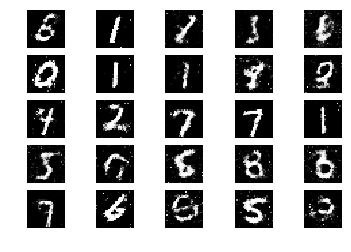

15000 [D loss: 0.647664, acc.: 60.94%] [G loss: 0.770817]


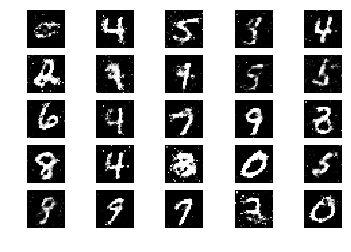

20000 [D loss: 0.708037, acc.: 54.69%] [G loss: 0.800862]


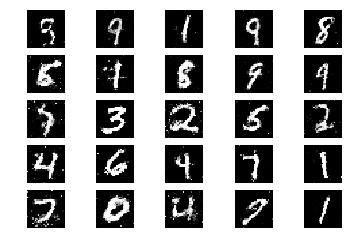

25000 [D loss: 0.685864, acc.: 54.69%] [G loss: 0.780385]


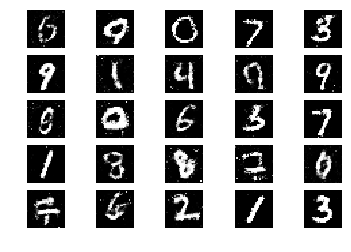

30000 [D loss: 0.726209, acc.: 42.19%] [G loss: 0.763454]


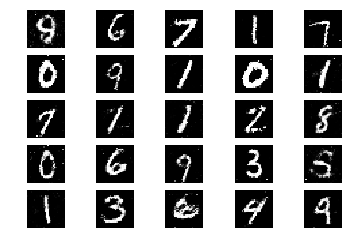

35000 [D loss: 0.733522, acc.: 54.69%] [G loss: 0.814746]


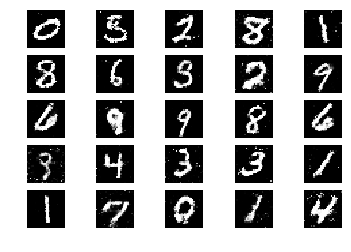

40000 [D loss: 0.727159, acc.: 51.56%] [G loss: 0.784112]


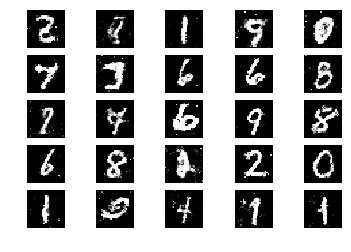

45000 [D loss: 0.668782, acc.: 62.50%] [G loss: 0.869950]


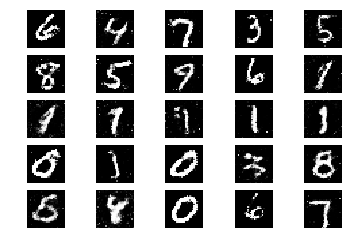

In [5]:
if __name__ == '__main__':
    gan = GAN()
    gan.train(epochs=50000, batch_size=64, save_interval=5000)